In [18]:
import pandas as pd
import numpy as np
from funlib.geometry import Roi
from tqdm import tqdm
import scipy
import matplotlib.pyplot as plt
from funlib.persistence import open_ds

annotation_csvs = [
    "../preprocessing/annotations_20230510_114340_dummy_removed.csv",  # original annotations (yellow)
    "../preprocessing/annotations_20230829_173628.csv",  # new region 1 (big yellow box, white annotations)
    "../preprocessing/annotations_20230929_115330.csv",  # new region 2 (cyan)
    "../preprocessing/annotations_20230929_115745.csv",  # new region 3 (purple)
    "../preprocessing/annotations_20230929_115914.csv",  # new regions 4 (pink) and 5 (green)
]

df = pd.concat([pd.read_csv(annotation_csv) for annotation_csv in annotation_csvs])

pd_starts = np.array([df["start x (nm)"], df["start y (nm)"], df["start z (nm)"]]).T / 8
pd_ends = np.array([df["end x (nm)"], df["end y (nm)"], df["end z (nm)"]]).T / 8
pd_centers = (
    pd_starts + pd_ends
) / 2  # np.round(((pd_starts + pd_ends) * 8 / 2)).astype(int)
pd_centers = np.round(pd_centers).astype(int) * 8
pad = 40
composite_image = np.zeros((pad * 2 + 1, pad * 2 + 1, pad * 2 + 1))


def get_rotation_matrix(v1, v2):
    # https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d/476311#476311
    if np.linalg.norm(np.cross(v1, v2)) > 0:
        ssc = lambda v: np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
        RU = (
            lambda v1, v2: np.identity(3)
            + ssc(np.cross(v1, v2))
            + np.dot(ssc(np.cross(v1, v2)), ssc(np.cross(v1, v2)))
            * (1 - np.dot(v1, v2))
            / (np.linalg.norm(np.cross(v1, v2)) ** 2)
        )
        rot = np.zeros((4, 4))
        rot[3, 3] = 1

        v1 = v1 / np.linalg.norm(v1)
        v2 = v2 / np.linalg.norm(v2)
        rot[:3, :3] = RU(v1, v2)
    else:
        rot = np.identity(4)
    return rot


ds = open_ds(
    "/nrs/cellmap/data/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5",
    "/em/fibsem-uint8/s0",
)

cyl = open_ds(
    "/nrs/cellmap/ackermand/cellmap/leaf-gall/jrc_22ak351-leaf-3m.n5",
    "plasmodesmata_as_cylinders",
)

count = 0
for pd_start, pd_end, pd_center in tqdm(
    zip(pd_starts, pd_ends, pd_centers), total=len(pd_centers)
):
    #
    # https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d/476311#476311
    v1 = pd_start - pd_end
    # v1 = np.array([1, 0, 0])
    v2 = np.array([0, 0, 1])
    rot = get_rotation_matrix(v1, v2)
    roi = Roi((pd_center - pad * 8)[::-1], [(pad * 2 + 1) * 8] * 3)
    #im = ds.to_ndarray(roi).swapaxes(0, 2)
    im = cyl.to_ndarray(roi).swapaxes(0, 2) > 0
    # im = np.zeros(im.shape)
    # im[90:110, 80:120, :] = 1
    # Translation matrix to shift the image center to the origin
    x, y, z = im.shape
    T = np.array(
        [
            [
                1,
                0,
                0,
                -x / 2.0,
            ],
            [0, 1, 0, -y / 2.0],
            [0, 0, 1, -z / 2.0],
            [0, 0, 0, 1],
        ]
    )
    im = scipy.ndimage.affine_transform(
        im, np.linalg.inv(np.linalg.inv(T).dot(rot).dot(T)), order=0
    )
    # im = scipy.ndimage.affine_transform(im, rot)
    # plt.imshow(im[:, :, 100], interpolation="None")
    composite_image += im
    count += 1
    if count > 100:
        break

  2%|▏         | 100/4427 [00:12<09:21,  7.71it/s]


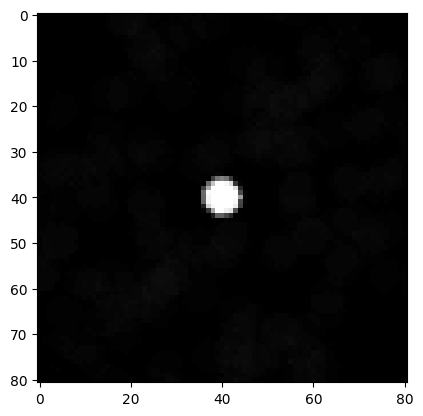

In [23]:
plt.imshow(composite_image[:, :, pad] / count, interpolation="None", cmap="gray")

In [28]:
composite_image.max() / len(pd_centers)

118.64490625705896

In [224]:
np.linalg.norm(pd_starts - pd_ends, axis=1).max()

76.13967234365614

In [221]:
np.linalg.norm([0, 2, 0])

2.0

In [23]:
import scipy

a = np.random.random((100, 100, 100))
im2 = scipy.ndimage.affine_transform(a, rot)

array([[[0.13217614, 0.03436011, 0.48445012, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.74471965, 0.51670868, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.75582204, 0.19582707, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.80849322, 0.28485224, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.48272313, 0.96036381, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.43811031, 0.61084556, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [6]:
np.identity(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

/tmp/ipykernel_23291/3252285421.py:7: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  image2 = scipy.ndimage.interpolation.rotate(


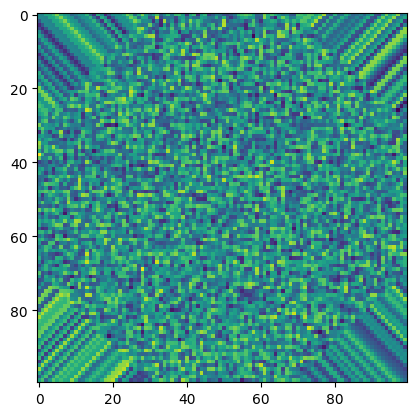

In [8]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

a = np.random.random((100, 100, 100))


image2 = scipy.ndimage.interpolation.rotate(
    a, 45, mode="nearest", axes=(0, 1), reshape=False
)
plt.imshow(image2[:, :, 1])